# Time Domain SHU Beam-Spreading Simulation
This notebook runs a Tidy3D time-domain simulation of beam spreading through a Stealthy Hyperuniform (SHU) particle arrangement.
- **Author / Project**: Francisco Hernandez

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import imageio
import matplotlib
import os

In [2]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]
web.configure(tidy3dAPI)

Configured successfully.


In [3]:
a = 1 #Characteristic length scale
permittivity_value = 11.56 #permittivity of the particles

## Key Simulation Parameters
- `a`: characteristic length scale (units used throughout notebook).
- `permittivity_value`: dielectric permittivity of the cylinders.
- `runtime_ps`: total simulated time (ps).
- `min_steps_per_lambda`: spatial resolution (points per wavelength).
- `lambdas_range`: wavelength range (in units of `a`) used to build the source pulse.
These variables are defined early so you can easily explore parameter sweeps by modifying them.

In [4]:
runtime_ps = 35e-12 #runtime in picoseconds (units used by Tidy3D)
min_steps_per_lambda = 20 #Spatial resolution (points per wavelength)

In [5]:
lambdas_range=a/np.array([0.25,0.27]) #Wavelength range close to the bandgap in units of a 

In [6]:
#Get points from a Stealthy Hyperuniform distribution with a chi value of 0.37
file_path = r'./structures/chi_0.37_N_10000_points.dat'
with open(file_path,"r") as f: 
    lines = f.read().splitlines() 
    info = lines[0]
    print(info) #print the header info (points, Lx, Ly)
    li = (lines[1:])
    centers = np.array([list(map(float, item.split())) for item in li])
    data = {
        "centers":centers,
        "Lx":float(info.split()[1]),
        "Ly":float(info.split()[2]),
        "points":int(info.split()[0]),
    }


       10006   100.029991       100.029991      #num partics, box.x,box.y


In [7]:
slicing= 0.09 #Size of the structure along the direction of propagation in units of a
lateral_size = 3 #Lateral size scaling factor

In [8]:
#Size of the simulation cell 
Lx, Ly = data['Lx']*lateral_size,data['Ly']*slicing+40
lambda0 = np.sum(lambdas_range)/2 #Central wavelength

In [9]:
#create the disordered structure by replicating the SHU pattern laterally
orig_Lx = data['Lx']
cyl_group = []
medium = td.Medium(permittivity=permittivity_value) #Permittivity of the particles
for s in range(lateral_size):
        shift = (s - (lateral_size - 1) / 2) * orig_Lx
        for x,y in data['centers']:
            if np.abs(y)<=(orig_Lx/2)*slicing:
                cyl_group.append(td.Cylinder(center=[x + shift, y, 0], radius=0.189, length=td.inf))
cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)

In [10]:
#Defining the source 
source = td.PlaneWave(
                source_time = td.GaussianPulse(
                    freq0=td.C_0/lambda0,
                    fwidth=(td.C_0/lambdas_range[1] - td.C_0/lambdas_range[0])*0.4,
                    offset=10
                    ),
                size= (4,0,td.inf), #4a wide in x focused-like beam), infinite in z
                center=(0,-(data['Lx'])*slicing/2 - 3,0),
                direction='+',
                pol_angle=np.pi/2,
                name='planewave',
                )

In [11]:
#Define Monitors to record the fields and fluxes
time_monitorField = td.FieldTimeMonitor(
                    center = (0,0,0),
                    size = (Lx,data["Lx"]*slicing,0),
                        start=0,
                        stop=runtime_ps,
                        interval=400,
                        fields=["Ex", "Ey", "Ez"],
                        name="time_monitorField",

                    )

flux_time_monitor = td.FluxTimeMonitor(
                        center = (
                                0,(data["Lx"]*slicing)/2+2,0
                                ),
                    size = (
                       td.inf,0,td.inf
                        ),
                        start=0,
                        stop=runtime_ps,
                        interval = 400,
                        name="flux_time_monitor",

                    )


In [12]:
#Boundary conditions of the simulation
#We put absorbers in x and y directions and periodic in z direction
boundaries= td.BoundarySpec(
                x=td.Boundary(plus=td.Absorber(num_layers=300),minus=td.Absorber(num_layers=300)), 
                y=td.Boundary(plus=td.Absorber(num_layers=300),minus=td.Absorber(num_layers=300)),
                z=td.Boundary.periodic(),
            )


In [13]:
dl = (lambdas_range[1] / min_steps_per_lambda)  #  grids per smallest wavelength in medium
sim = td.Simulation(
            center = (0, 0, 0),
            size = (Lx, Ly, 0),
            grid_spec = td.GridSpec.uniform(dl=dl),
            sources = [source],
            monitors = [time_monitorField,flux_time_monitor],
            run_time = runtime_ps,
            shutoff = 1e-20, #Simulation stops when field has decayed to this 
            boundary_spec = boundaries,
            normalize_index = None,
            structures = [cylinders],
            )

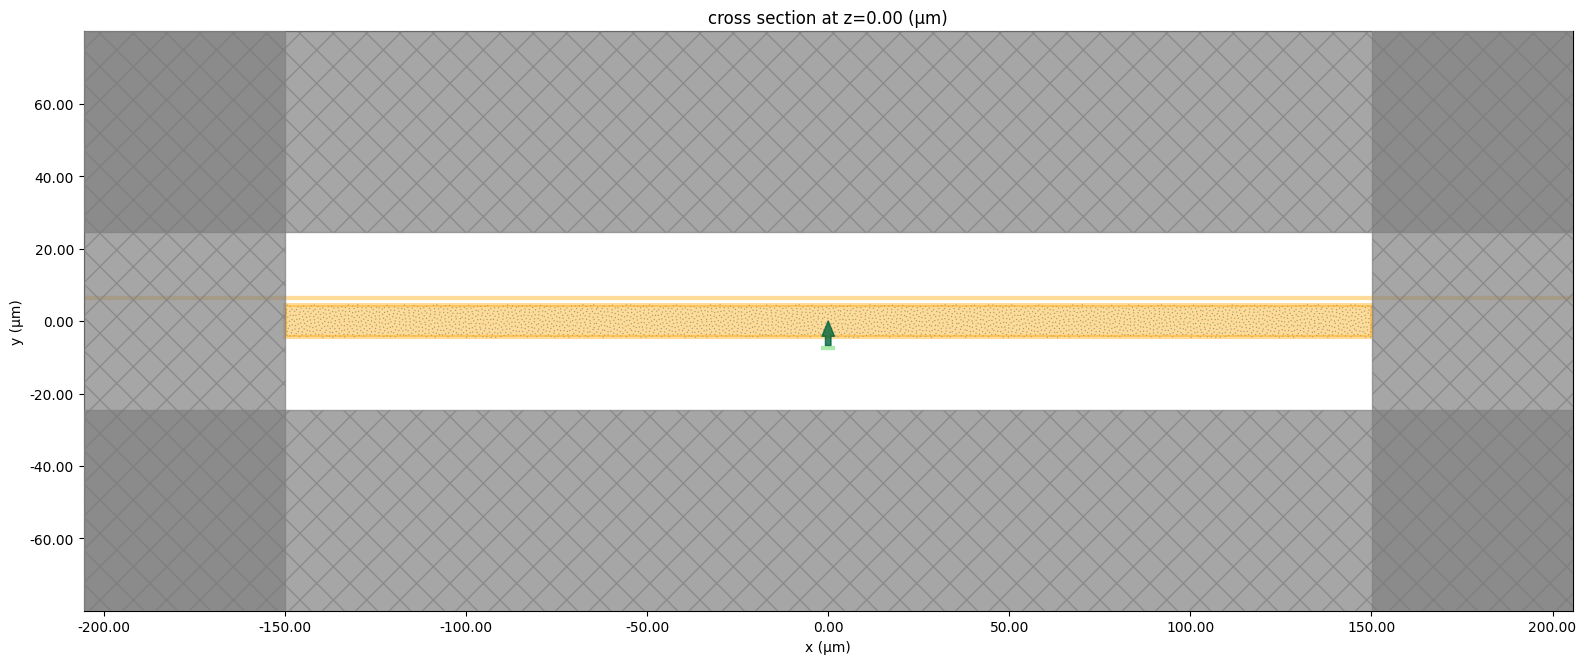

In [14]:
#Visualize the simulation setup
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
sim.plot(z=0, ax=ax)
plt.show()

## Run Notes & Monitoring
- The notebook records both `time_monitorField` (field snapshots) and `flux_time_monitor` (flux at the exit).
- To re-run with different parameters: update the parameter cells (variables above), re-run the setup cells, then execute the `web.run` cell.
- Large simulations may take significant time and resources on the Tidy3D cloud — reduce `runtime_ps` or `lateral_size` for quicker tests.

In [15]:
#Run the simulation
sim_data = web.run(sim, task_name="SHU_Beam_Spreading_Time_Domain")

15:53:18 W. Europe Standard Time Created task 'SHU_Beam_Spreading_Time_Domain'  
                                 with task_id                                   
                                 'fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=960477;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=929128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\task]8;;\
                                 ]8;id=929128;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\Id]8;;\]8;id=960477;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\=]8;;\]8;id=706087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\fdve]8;;\]8;id=960477;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\-23f213b9-bd5b-4d15-bcc4-e4667fc74faa']8;;\.

                                 Task folder: ]8;id=112452;https://tidy3d.simulation.cloud/folders/folder-c559d4c5-ca60-4424-8c91-9e13d88be266\'default']8;;\.

Output()

15:53:22 W. Europe Standard Time Maximum FlexCredit cost: 0.047. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

15:53:23 W. Europe Standard Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

15:53:30 W. Europe Standard Time status = preprocess

15:53:34 W. Europe Standard Time starting up solver

15:53:35 W. Europe Standard Time running solver

Output()

15:53:53 W. Europe Standard Time status = postprocess

Output()

15:54:04 W. Europe Standard Time status = success

15:54:06 W. Europe Standard Time View simulation result at                      
                                 ]8;id=734531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=187054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\task]8;;\
                                 ]8;id=187054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\Id]8;;\]8;id=734531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\=]8;;\]8;id=357695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\fdve]8;;\]8;id=734531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23f213b9-bd5b-4d15-bcc4-e4667fc74faa\-23f213b9-bd5b-4d15-bcc4-e4667fc74faa']8;;\.

Output()

15:54:24 W. Europe Standard Time loading simulation from simulation_data.hdf5

15:54:25 W. Europe Standard Time WARNING: Simulation final field decay value of 
                                 1.13e-11 is greater than the simulation shutoff
                                 threshold of 1e-20. Consider running the       
                                 simulation again with a larger 'run_time'      
                                 duration for more accurate results.            

In [16]:
#Get monitor field intensity
intensity=(sim_data.get_intensity("time_monitorField").values).squeeze()
time_ps = (sim_data.get_intensity("time_monitorField").t).values * 1e12
x = (sim_data.get_intensity("time_monitorField").x).values
y = (sim_data.get_intensity("time_monitorField").y).values
intensity.shape #(Nx, Ny,Ntime)

(1624, 50, 203)

In [17]:
intensity_exit = intensity[:,-1,:]# Intensity at the exit plane over time
intensity_exit_normalized = intensity_exit/(np.max(intensity_exit,axis=0))

C:\Users\HernandF\AppData\Local\Temp\ipykernel_23448\2328698108.py:2: RuntimeWarning: invalid value encountered in divide
  intensity_exit_normalized = intensity_exit/(np.max(intensity_exit,axis=0))


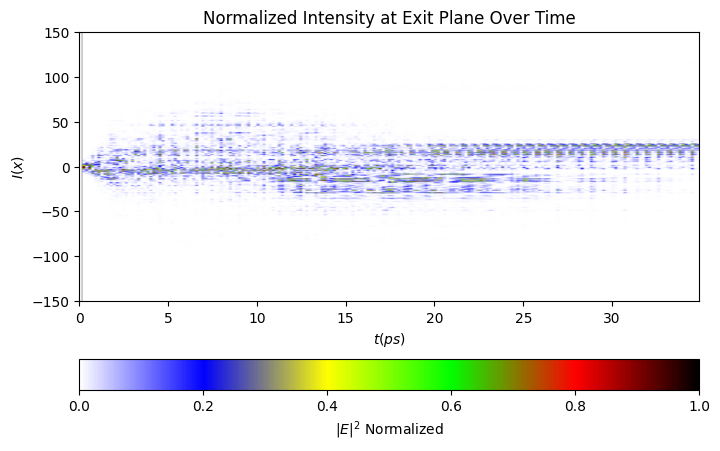

In [20]:
#plot intensity at exit plane over time

import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
# Create a custom colormap
colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

fig, ax = plt.subplots(
    figsize=(8,5)
)

im = ax.imshow(intensity_exit_normalized,vmin = 0, vmax = 1, 
                     extent =[np.min(time_ps),np.max(time_ps),np.min(x),np.max(x)], 
                         origin ='lower', cmap=cmap,aspect='auto')
ax.set_ylabel(r"$I(x)$")
ax.set_xlabel(r"$t(ps)$")
cbar = fig.colorbar(im, ax=ax,orientation='horizontal')
cbar.set_label(rf"$|E|^2$ Normalized")
cbar.ax.xaxis.set_label_position('bottom')
ax.set_title("Normalized Intensity at Exit Plane Over Time")

plt.show()
